In [1]:
import os
import shutil

### 폴더명 변경하기

In [2]:
folder_path = './엣지/'

In [3]:
tattoo_categori_list = os.listdir(folder_path)
tattoo_categori_list

['test', 'train', 'validation']

### train, validation, test 셋트로 분리하기

In [4]:
tattoo_categori_list = os.listdir(folder_path)
for folder_name in tattoo_categori_list :
    print(folder_name, len(os.listdir(folder_path+folder_name)))

test 6
train 6
validation 6


### 5(train) : 2(validation) : 3(test)

In [5]:
train_path = os.path.join(folder_path,'train')
validation_path = os.path.join(folder_path,'validation')
test_path = os.path.join(folder_path,'test')
print(train_path) 
print(validation_path)
print(test_path)

./엣지/train
./엣지/validation
./엣지/test


### raw-image to numpy

In [6]:
from PIL import Image, ImageOps
import numpy as np

In [7]:
# 전체 사진 불러오는 함수
def load_images(folder_path,file_names,img_size_shape):
    images = []                                          # 불러올 사진을 담을 리스트
    
    for i in range(len(file_names)):
        path = os.path.join(folder_path,file_names[i])   # 사진경로 생성
        img = Image.open(path).resize(img_size_shape)    # 이미지 오픈 후 리사이징
        img = img.convert('RGB')                         # PNG -> RGB
        images.append(np.array(img))                     # numpy배열로 변환 후 리스트에 추가
   
    return images

In [8]:
tattoo_dir_list = os.listdir(train_path)   # 타투 폴더 이름 가져오기
tattoo_dir_list

['고래', '꽃', '나비', '달', '십자가', '하트']

In [9]:
X_train = []
y_train = []
# train data
for tattoo_dir in tattoo_dir_list :
    print(tattoo_dir)
    path = os.path.join(folder_path,'train',tattoo_dir)  # 경로 만들기
    file_names = os.listdir(path)                        # 파일 이름 얻기
    data = load_images(path, file_names, (224,224))      # 이미지 로드
    print(len(data))
    y_train = y_train + [tattoo_dir] * len(data)         # 정답 만들기
    X_train = X_train + data                             # 이미지 병합

X_train = np.array(X_train)
y_train = np.array(y_train)

고래
1513
꽃
2120
나비
2259
달
1281
십자가
1629
하트
1782


In [10]:
print(X_train.shape)
print(y_train.shape)

(10584, 224, 224, 3)
(10584,)


In [11]:
X_validation = []
y_validation = []
# validation data
for tattoo_dir in tattoo_dir_list :
    print(tattoo_dir)
    path = os.path.join(folder_path,'validation',tattoo_dir)     # 경로 만들기
    file_names = os.listdir(path)                                # 파일 이름 얻기
    data = load_images(path, file_names, (224,224))              # 이미지 로드
    print(len(data))
    y_validation = y_validation + [tattoo_dir] * len(data)       # 정답 만들기
    X_validation = X_validation + data                           # 이미지 병합

X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

고래
605
꽃
848
나비
904
달
512
십자가
652
하트
713


In [12]:
print(X_validation.shape)
print(y_validation.shape)

(4234, 224, 224, 3)
(4234,)


In [13]:
X_test = []
y_test = []
# test data
for tattoo_dir in tattoo_dir_list :
    print(tattoo_dir)
    path = os.path.join(folder_path,'test',tattoo_dir)           # 경로 만들기
    file_names = os.listdir(path)                                # 파일 이름 얻기
    data = load_images(path, file_names, (224,224))              # 이미지 로드
    print(len(data))
    y_test = y_test + [tattoo_dir] * len(data)                   # 정답 만들기
    X_test = X_test + data                                       # 이미지 병합

X_test = np.array(X_test)
y_test = np.array(y_test)

고래
908
꽃
1272
나비
1356
달
769
십자가
978
하트
1070


In [14]:
print(X_test.shape)
print(y_test.shape)

(6353, 224, 224, 3)
(6353,)


### 모델링

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import pandas as pd

In [16]:
y_train_one_hot = pd.get_dummies(y_train)
y_validation_one_hot = pd.get_dummies(y_validation)
y_test_one_hot = pd.get_dummies(y_test)

In [17]:
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))
print(conv_base.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
from tensorflow.keras.models import load_model

vgg19_model = Sequential()
vgg19_model.add(conv_base)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(256,activation='relu'))
vgg19_model.add(Dense(6,activation='softmax'))
print(vgg19_model.summary())
conv_base.trainable=True
print(len(vgg19_model.trainable_weights))
conv_base.trainable=False
print(len(vgg19_model.trainable_weights))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 26,448,710
Trainable params: 26,448,710
Non-trainable params: 0
_________________________________________________________________
None
36
4


In [19]:
vgg19_model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [20]:
path = "./model/Tattoo_10_Model_{epoch:03d}_{val_accuracy:.4f}.hdf5"
mckp = ModelCheckpoint(filepath = path,
                      monitor = 'val_accuracy',
                      verbose=1,
                      save_best_only=True)

In [22]:
vgg19_history = vgg19_model.fit(X_train,y_train_one_hot,
         validation_data=(X_validation,y_validation_one_hot),
         epochs = 7,
         batch_size = 50,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
         callbacks=[mckp])

Epoch 1/7
212/212 [==============================] - ETA: 0s - loss: 1.7634e-04 - accuracy: 1.0000
Epoch 00001: val_accuracy did not improve from 1.00000
212/212 [==============================] - 46s 218ms/step - loss: 1.7634e-04 - accuracy: 1.0000 - val_loss: 3.5541e-04 - val_accuracy: 1.0000
Epoch 2/7
212/212 [==============================] - ETA: 0s - loss: 9.8182e-05 - accuracy: 1.0000
Epoch 00002: val_accuracy did not improve from 1.00000
212/212 [==============================] - 46s 218ms/step - loss: 9.8182e-05 - accuracy: 1.0000 - val_loss: 2.5706e-04 - val_accuracy: 1.0000
Epoch 3/7
212/212 [==============================] - ETA: 0s - loss: 7.1117e-05 - accuracy: 1.0000
Epoch 00003: val_accuracy did not improve from 1.00000
212/212 [==============================] - 46s 219ms/step - loss: 7.1117e-05 - accuracy: 1.0000 - val_loss: 2.2443e-04 - val_accuracy: 1.0000
Epoch 4/7
212/212 [==============================] - ETA: 0s - loss: 5.3427e-05 - accuracy: 1.0000
Epoch 00004: 

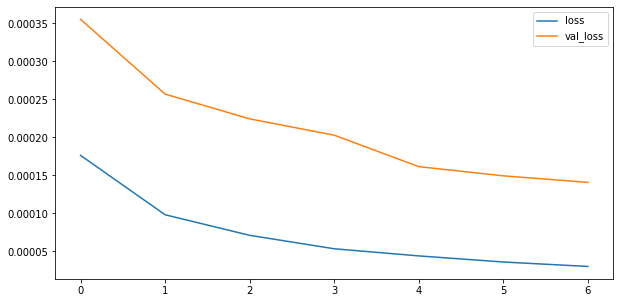

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5)) # 가로,세로 사이즈
plt.plot(vgg19_history.history['loss'], label='loss')
plt.plot(vgg19_history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

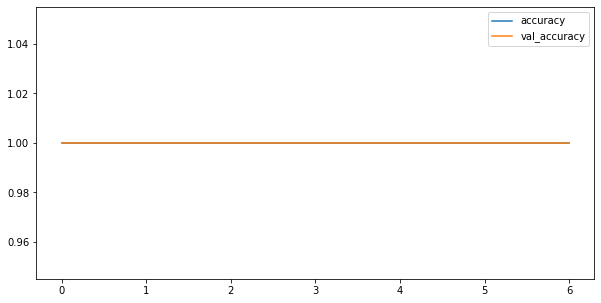

In [25]:
plt.figure(figsize=(10,5)) # 가로,세로 사이즈
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [26]:
vgg19_model.evaluate(X_test,y_test_one_hot)

199/199 [==============================] - 18s 91ms/step - loss: 2.4649e-04 - accuracy: 1.0000


[0.00024649323313497007, 1.0]

### 모델 로딩하기

In [4]:
from tensorflow.keras.models import load_model

best_model = load_model('./model/Tattoo_10_Model_002_1.0000.hdf5')

In [ ]:
best_model.predict_classes(X_test)

In [ ]:
best_model.evaluate(X_test,y_test_one_hot)

### 모델 예측

In [2]:
tattoo_dir_list = ['고래', '꽃', '나비', '달', '십자가', '하트']

In [6]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from PIL import Image, ImageOps

PATH = './엣지엣지/butterfly_21.jpg'
    
img = Image.open(PATH).resize((224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "\nThis image most likely belongs to {} with a {:.2f} percent confidence."
    .format(tattoo_dir_list[np.argmax(score)], 100 * np.max(score))
)

fold_name = tattoo_dir_list[np.argmax(score)]

tf.Tensor([0.12956251 0.12956251 0.35218737 0.12956251 0.12956251 0.12956251], shape=(6,), dtype=float32)

This image most likely belongs to 나비 with a 35.22 percent confidence.


### image similarity

In [7]:
from PIL import Image
import numpy as np
import os, re

# 파일 경로 지정하기
search_dir = os.getcwd() + "\\추려추려\\" + fold_name
cache_dir = os.getcwd() + "\\추려추려\\cache_avhash"
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

# 이미지 데이터를 Average Hash로 변화하기
def average_hash(fname,size=16):
    fname2 = fname[len(search_dir):]
    
    #이미지 캐시하기
    cache_file = cache_dir + "\\" + fname2.replace('\\','_') + ".csv"
    if not os.path.exists(cache_file):  # 해시 생성하기
        img = Image.open(fname)
        img = img.convert('L').resize((size, size), Image.ANTIALIAS)
        pixels = np.array(img.getdata()).reshape((size, size))
        avg = pixels.mean()
        px = 1 * (pixels > avg)
        np.savetxt(cache_file, px, fmt="%.0f", delimiter=",")
    else: 
        px = np.loadtxt(cache_file, delimiter=",")
    return px

#해밍 거리 구하기
def hamming_dist(a,b):
    aa = a.reshape(1,-1)      # 1차원 배열로 변환
    ab = b.reshape(1,-1)
    dist = (aa != ab).sum()
    return dist

# 모든 폴더의 이미지 파일에 처리 적용하기
def enum_all_files(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            fname = os.path.join(root,f)
            if re.search(r'\.(jpg|jpeg|png)$',fname):
                yield fname

def fine_image(fname, rate):
    src = average_hash(fname)

    for fname in enum_all_files(search_dir):
        dst = average_hash(fname)
        diff_r = hamming_dist(src, dst) / 256
        #print("[check]",fname)
        if diff_r < rate:
            yield (diff_r,fname)

# 찾기
#srcfile = search_dir + "\\whale_28.jpg"
srcfile = PATH
html = ""
sim = list(fine_image(srcfile, 1.5))
sim = sorted(sim[:5], key=lambda x:x[0])

image_addr = []
# 비슷한 이미지를 찾은 결과(해밍거리 0.25 미만)를 이렇게 html파일로 만들어서 저장
for r,f in sim:
    print(r,">",f)
    s = '<div style="float:left;"><h3>[차이 :' + str(r) + '-' + \
        os.path.basename(f) + ']</h3>' + \
        '<p><a href= "' + f + '"><img src="'+f+'"width=400>'+ \
        '</a></p></div>'
    html += s
    image_addr.append(f)

#HTML로 출력
html = """<html><head><meta charset="utf8"></head> 
<body><h3>원래 이미지</h3><p>
<img src='{0}' width=400></p>{1}
</body></html>""".format(srcfile, html)

with open("./avhash-search-output.html", "w", encoding="utf-8") as f:
    f.write(html)
print("ok")

0.73046875 > C:\Users\SM107\3차 프로젝트\추려추려\나비\0004.jpg
0.7890625 > C:\Users\SM107\3차 프로젝트\추려추려\나비\0018.jpg
0.80859375 > C:\Users\SM107\3차 프로젝트\추려추려\나비\0027.jpg
0.8125 > C:\Users\SM107\3차 프로젝트\추려추려\나비\0001.jpg
0.90625 > C:\Users\SM107\3차 프로젝트\추려추려\나비\0042.jpg
ok


## flask 연동

In [6]:
import tensorflow as tf
import numpy as np
import os, re
from tensorflow.keras.models import load_model
from tensorflow import keras
from PIL import Image, ImageOps

# 이미지 데이터를 Average Hash로 변화하기
def average_hash(fname,size=16):
    fname2 = fname[len(search_dir):]
    
    #이미지 캐시하기
    cache_file = cache_dir + "\\" + fname2.replace('\\','_') + ".csv"
    if not os.path.exists(cache_file):  # 해시 생성하기
        img = Image.open(fname)
        img = img.convert('L').resize((size, size), Image.ANTIALIAS)
        pixels = np.array(img.getdata()).reshape((size, size))
        avg = pixels.mean()
        px = 1 * (pixels > avg)
        np.savetxt(cache_file, px, fmt="%.0f", delimiter=",")
    else: 
        px = np.loadtxt(cache_file, delimiter=",")
    return px

#해밍 거리 구하기
def hamming_dist(a,b):
    aa = a.reshape(1,-1)      # 1차원 배열로 변환
    ab = b.reshape(1,-1)
    dist = (aa != ab).sum()
    return dist

# 모든 폴더의 이미지 파일에 처리 적용하기
def enum_all_files(path):
    for root, dirs, files in os.walk(path):
        for f in files:
            fname = os.path.join(root,f)
            if re.search(r'\.(jpg|jpeg|png)$',fname):
                yield fname

def fine_image(fname, rate):
    src = average_hash(fname)

    for fname in enum_all_files(search_dir):
        dst = average_hash(fname)
        diff_r = hamming_dist(src, dst) / 256
        #print("[check]",fname)
        if diff_r < rate:
            yield (diff_r,fname)

In [ ]:
from flask import Flask, redirect, url_for, request, Response, render_template
from flask import send_file

app = Flask(__name__)

@app.route('/draw/flower', methods = ['POST', 'GET'])
def draw():
    num = 3
    
    return send_file('./추려추려/' + str(num) + '.jpg', mimetype='image/jpeg')

@app.route('/draw', methods = ['POST', 'GET'])
def draw2():

    return send_file(request.args['img_url'], mimetype='image/jpeg')

@app.route('/', methods = ['POST', 'GET'])
def home():
    return render_template('avhash-search-output.html') #localhost:9000 기본 서버 열었을 때 템플릿으로 이동 아무것도 없는 껍데기


#자바 서블릿단에서 파일명 받아와서 동작하는 함수
@app.route('/painting', methods = ['POST', 'GET'])
def painting():
    file_name = request.args['file_name']
 
    #PATH = './엣지엣지/butterfly_21.jpg' ## 사용자가 그린 도안의 경로 넣기 자바에서 값을 어떻게 불러오지 변수가 있어야됨. 고정경로+이미지명
    PATH = r'C:\Users\SM120\Desktop\Re\.metadata\.plugins\org.eclipse.wst.server.core\tmp0\wtpwebapps\Tattoo\upload\{}'.format(file_name)

        # 이미지 데이터를 Average Hash로 변화하기
    def average_hash(fname,size=16):
        fname2 = fname[len(search_dir):]

        #이미지 캐시하기
        cache_file = cache_dir + "\\" + fname2.replace('\\','_') + ".csv"
        if not os.path.exists(cache_file):  # 해시 생성하기
            img = Image.open(fname)
            img = img.convert('L').resize((size, size), Image.ANTIALIAS)
            pixels = np.array(img.getdata()).reshape((size, size))
            avg = pixels.mean()
            px = 1 * (pixels > avg)
            np.savetxt(cache_file, px, fmt="%.0f", delimiter=",")
        else: 
            px = np.loadtxt(cache_file, delimiter=",")
        return px

    #해밍 거리 구하기
    def hamming_dist(a,b):
        aa = a.reshape(1,-1)      # 1차원 배열로 변환
        ab = b.reshape(1,-1)
        dist = (aa != ab).sum()
        return dist

    # 모든 폴더의 이미지 파일에 처리 적용하기
    def enum_all_files(path):
        for root, dirs, files in os.walk(path):
            for f in files:
                fname = os.path.join(root,f)
                if re.search(r'\.(jpg|jpeg|png)$',fname):
                    yield fname

    def fine_image(fname, rate):
        src = average_hash(fname)

        for fname in enum_all_files(search_dir):
            dst = average_hash(fname)
            diff_r = hamming_dist(src, dst) / 256
            #print("[check]",fname)
            if diff_r < rate:
                yield (diff_r,fname)

            
    img = Image.open(PATH).resize((224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    tattoo_dir_list = ['고래', '꽃', '나비', '달', '십자가', '하트']

    best_model = load_model('./model/Tattoo_10_Model_002_1.0000.hdf5')
    predictions = best_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(score)
    print(
        "\nThis image most likely belongs to {} with a {:.2f} percent confidence."
        .format(tattoo_dir_list[np.argmax(score)], 100 * np.max(score))
    )

    fold_name = tattoo_dir_list[np.argmax(score)]   
    print(fold_name)

    # 파일 경로 지정하기
    #search_dir = './templates/' + fold_name
    search_dir = './추려추려/' + fold_name
    print(search_dir) #추려추려/이름
    cache_dir = './추려추려/cache_avhash'

    if not os.path.exists(cache_dir):
        os.mkdir(cache_dir)
        
    # 찾기
    srcfile = PATH
    html = ""
    sim = list(fine_image(srcfile, 1.5))
    sim = sorted(sim[:5], key=lambda x:x[0])

    image_addr = [] 
    # 비슷한 이미지를 찾은 결과(해밍거리 0.25 미만)를 이렇게 html파일로 만들어서 저장
    for r,f in sim:
        print(r,">",f)
        s = '<div style="float:left;"><h3>[차이 :' + str(r) + '-' + \
            os.path.basename(f) + ']</h3>' + \
            '<p><a href= "' + f + '"><img src="'+f+'"width=400>'+ \
            '</a></p></div>'
        html += s
        image_addr.append(f)
        

    #HTML로 출력
    html = """<html><head><meta charset="utf8"></head> 
    <body><h3>원래 이미지</h3><p>
    <img src='{0}' width=400></p>{1}
    </body></html>""".format(srcfile, html)

    with open("./avhash-search-output.html", "w", encoding="utf-8") as f:
        f.write(html)
    print("ok") #여기까지 잘 됨.

    
    #이 주소가 아니라 다른 다른 
    #return render_template('avhash-search-output.html')

    #http://localhost:9000/painting?file_name={}.format(file_name)  이 주소로 이동하면서 사진도 띄워야됨

    # redirect로  값을 반환해주는 페이지 이동하면서 이미지도 가져감..  쿼리스트링으로 배열은 못넘기고 대신 ,를 써서 join으로넘김
    # cnn.result 로 가려면 저기 주소 바꿔야한다.
    return redirect('http://localhost:8088/Tattoo/avhash-search-output.jsp?file_name={}'.format(",".join(image_addr)))
    
    print("ok2")


    
# 무조건 맨 마지막    
if __name__ == "__main__":
    app.run(host="localhost", port="9000")   

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Nov/2020 12:17:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:17:56] "GET /엣지엣지/butterfly_21.jpg HTTP/1.1" 404 -


127.0.0.1 - - [26/Nov/2020 12:18:22] "GET /painting?file_name=myPainting%20(21)4.jpg HTTP/1.1" 302 -


tf.Tensor([0.35218745 0.12956253 0.12956253 0.12956253 0.12956253 0.12956253], shape=(6,), dtype=float32)

This image most likely belongs to 고래 with a 35.22 percent confidence.
고래
./추려추려/고래
0.23046875 > ./추려추려/고래\0004.jpg
0.26171875 > ./추려추려/고래\0051.jpg
0.28125 > ./추려추려/고래\0059.jpg
0.3125 > ./추려추려/고래\0005.jpg
0.328125 > ./추려추려/고래\0042.jpg
ok
tf.Tensor([0.12956251 0.12956251 0.12956251 0.12956251 0.12956251 0.35218742], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.22 percent confidence.
하트
./추려추려/하트


127.0.0.1 - - [26/Nov/2020 12:19:05] "GET /painting?file_name=myPainting%20(25)1.jpg HTTP/1.1" 302 -


0.19921875 > ./추려추려/하트\0003.jpg
0.20703125 > ./추려추려/하트\0001.jpg
0.20703125 > ./추려추려/하트\0002.jpg
0.3046875 > ./추려추려/하트\0004.jpg
0.32421875 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:19:06] "GET /draw?img_url=./추려추려/하트\0001.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:06] "GET /draw?img_url=./추려추려/하트\0003.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:06] "GET /draw?img_url=./추려추려/하트\0002.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:06] "GET /draw?img_url=./추려추려/하트\0004.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:06] "GET /draw?img_url=./추려추려/하트\0005.jpg HTTP/1.1" 200 -


tf.Tensor([0.12956251 0.12956251 0.12956251 0.35218737 0.12956251 0.12956251], shape=(6,), dtype=float32)

This image most likely belongs to 달 with a 35.22 percent confidence.
달
./추려추려/달


127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /painting?file_name=myPainting%20(26).jpg HTTP/1.1" 302 -


0.15625 > ./추려추려/달\0047.jpg
0.16015625 > ./추려추려/달\0029.jpg
0.16796875 > ./추려추려/달\0022.jpg
0.23046875 > ./추려추려/달\0010.jpg
0.25390625 > ./추려추려/달\0015.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /draw?img_url=./추려추려/달\0047.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /draw?img_url=./추려추려/달\0029.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /draw?img_url=./추려추려/달\0022.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /draw?img_url=./추려추려/달\0015.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:19:25] "GET /draw?img_url=./추려추려/달\0010.jpg HTTP/1.1" 200 -


tf.Tensor([0.13055666 0.3425506  0.13055666 0.13370791 0.13055666 0.13207164], shape=(6,), dtype=float32)

This image most likely belongs to 꽃 with a 34.26 percent confidence.
꽃
./추려추려/꽃


127.0.0.1 - - [26/Nov/2020 12:22:11] "GET /painting?file_name=myPainting%20(27).jpg HTTP/1.1" 302 -
127.0.0.1 - - [26/Nov/2020 12:22:11] "GET /draw?img_url=./추려추려/꽃\0011.jpg HTTP/1.1" 200 -


0.14453125 > ./추려추려/꽃\0011.jpg
0.15234375 > ./추려추려/꽃\0038.jpg
0.16015625 > ./추려추려/꽃\0029.jpg
0.19921875 > ./추려추려/꽃\0006.jpg
0.37109375 > ./추려추려/꽃\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:22:12] "GET /draw?img_url=./추려추려/꽃\0038.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:22:12] "GET /draw?img_url=./추려추려/꽃\0006.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:22:12] "GET /draw?img_url=./추려추려/꽃\0029.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:22:12] "GET /draw?img_url=./추려추려/꽃\0005.jpg HTTP/1.1" 200 -


127.0.0.1 - - [26/Nov/2020 12:24:00] "GET /painting?file_name=myPainting%20(28).jpg HTTP/1.1" 302 -


tf.Tensor([0.12956253 0.12956253 0.12956253 0.35218745 0.12956253 0.12956253], shape=(6,), dtype=float32)

This image most likely belongs to 달 with a 35.22 percent confidence.
달
./추려추려/달
0.27734375 > ./추려추려/달\0022.jpg
0.28515625 > ./추려추려/달\0010.jpg
0.28515625 > ./추려추려/달\0029.jpg
0.2890625 > ./추려추려/달\0047.jpg
0.30859375 > ./추려추려/달\0015.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:24:27] "GET /painting?file_name=myPainting%20(29).jpg HTTP/1.1" 302 -


tf.Tensor([0.13708018 0.13708007 0.13708007 0.1379597  0.21820395 0.23259604], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 23.26 percent confidence.
하트
./추려추려/하트
0.1953125 > ./추려추려/하트\0003.jpg
0.21875 > ./추려추려/하트\0002.jpg
0.234375 > ./추려추려/하트\0001.jpg
0.31640625 > ./추려추려/하트\0004.jpg
0.3671875 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:25:14] "GET /painting?file_name=myPainting%20(30).jpg HTTP/1.1" 302 -


tf.Tensor([0.12956251 0.12956251 0.12956251 0.12956251 0.12956251 0.35218742], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.22 percent confidence.
하트
./추려추려/하트
0.296875 > ./추려추려/하트\0001.jpg
0.296875 > ./추려추려/하트\0002.jpg
0.3203125 > ./추려추려/하트\0003.jpg
0.375 > ./추려추려/하트\0005.jpg
0.37890625 > ./추려추려/하트\0004.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:25:30] "GET /painting?file_name=myPainting%20(31).jpg HTTP/1.1" 302 -


tf.Tensor([0.29745942 0.13438928 0.134423   0.16486117 0.13438518 0.1344819 ], shape=(6,), dtype=float32)

This image most likely belongs to 고래 with a 29.75 percent confidence.
고래
./추려추려/고래
0.2578125 > ./추려추려/고래\0059.jpg
0.26953125 > ./추려추려/고래\0051.jpg
0.2890625 > ./추려추려/고래\0042.jpg
0.375 > ./추려추려/고래\0005.jpg
0.37890625 > ./추려추려/고래\0004.jpg
ok
tf.Tensor([0.12991723 0.34878898 0.12991723 0.13153456 0.12991723 0.12992483], shape=(6,), dtype=float32)

This image most likely belongs to 꽃 with a 34.88 percent confidence.
꽃
./추려추려/꽃


127.0.0.1 - - [26/Nov/2020 12:28:06] "GET /painting?file_name=myPainting%20(32).jpg HTTP/1.1" 302 -


0.2265625 > ./추려추려/꽃\0006.jpg
0.234375 > ./추려추려/꽃\0011.jpg
0.2578125 > ./추려추려/꽃\0038.jpg
0.2734375 > ./추려추려/꽃\0029.jpg
0.3203125 > ./추려추려/꽃\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:29:47] "GET /painting?file_name=myPainting%20(33).jpg HTTP/1.1" 302 -


tf.Tensor([0.12958401 0.12958746 0.12962943 0.12962931 0.12958656 0.35198322], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.20 percent confidence.
하트
./추려추려/하트
0.09375 > ./추려추려/하트\0002.jpg
0.171875 > ./추려추려/하트\0003.jpg
0.1875 > ./추려추려/하트\0001.jpg
0.27734375 > ./추려추려/하트\0004.jpg
0.375 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:30:43] "GET /painting?file_name=myPainting%20(34).jpg HTTP/1.1" 302 -


tf.Tensor([0.12956251 0.12956254 0.12956251 0.12956251 0.12956251 0.35218734], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.22 percent confidence.
하트
./추려추려/하트
0.08984375 > ./추려추려/하트\0002.jpg
0.19140625 > ./추려추려/하트\0001.jpg
0.19921875 > ./추려추려/하트\0003.jpg
0.2578125 > ./추려추려/하트\0004.jpg
0.42578125 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:30:59] "GET /painting?file_name=myPainting%20(32)1.jpg HTTP/1.1" 302 -


tf.Tensor([0.12991723 0.34878898 0.12991723 0.13153456 0.12991723 0.12992483], shape=(6,), dtype=float32)

This image most likely belongs to 꽃 with a 34.88 percent confidence.
꽃
./추려추려/꽃
0.2265625 > ./추려추려/꽃\0006.jpg
0.234375 > ./추려추려/꽃\0011.jpg
0.2578125 > ./추려추려/꽃\0038.jpg
0.2734375 > ./추려추려/꽃\0029.jpg
0.3203125 > ./추려추려/꽃\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:31:25] "GET /painting?file_name=myPainting%20(35).jpg HTTP/1.1" 302 -


tf.Tensor([0.12956251 0.12956251 0.12956251 0.12956251 0.12956251 0.35218742], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.22 percent confidence.
하트
./추려추려/하트
0.140625 > ./추려추려/하트\0002.jpg
0.171875 > ./추려추려/하트\0001.jpg
0.1953125 > ./추려추려/하트\0003.jpg
0.26171875 > ./추려추려/하트\0004.jpg
0.3671875 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:31:48] "GET /painting?file_name=myPainting%20(36).jpg HTTP/1.1" 302 -


tf.Tensor([0.1295667  0.12956963 0.1295667  0.12958257 0.1295667  0.35214773], shape=(6,), dtype=float32)

This image most likely belongs to 하트 with a 35.21 percent confidence.
하트
./추려추려/하트
0.125 > ./추려추려/하트\0002.jpg
0.1484375 > ./추려추려/하트\0001.jpg
0.2265625 > ./추려추려/하트\0003.jpg
0.26953125 > ./추려추려/하트\0004.jpg
0.40625 > ./추려추려/하트\0005.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:33:52] "GET /painting?file_name=myPainting%20(37).jpg HTTP/1.1" 302 -


tf.Tensor([0.13045754 0.13043751 0.13043751 0.34368256 0.13454707 0.13043788], shape=(6,), dtype=float32)

This image most likely belongs to 달 with a 34.37 percent confidence.
달
./추려추려/달
0.21484375 > ./추려추려/달\0010.jpg
0.2421875 > ./추려추려/달\0047.jpg
0.24609375 > ./추려추려/달\0029.jpg
0.25390625 > ./추려추려/달\0022.jpg
0.28515625 > ./추려추려/달\0015.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:34:36] "GET /painting?file_name=myPainting%20(38).jpg HTTP/1.1" 302 -


tf.Tensor([0.12968104 0.12966403 0.1300986  0.3512214  0.12966403 0.12967089], shape=(6,), dtype=float32)

This image most likely belongs to 달 with a 35.12 percent confidence.
달
./추려추려/달
0.18359375 > ./추려추려/달\0022.jpg
0.18359375 > ./추려추려/달\0029.jpg
0.1875 > ./추려추려/달\0047.jpg
0.22265625 > ./추려추려/달\0010.jpg
0.23046875 > ./추려추려/달\0015.jpg
ok
tf.Tensor([0.12976204 0.12976621 0.35029545 0.12986012 0.1305545  0.12976162], shape=(6,), dtype=float32)

This image most likely belongs to 나비 with a 35.03 percent confidence.
나비
./추려추려/나비


127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /painting?file_name=myPainting%20(39).jpg HTTP/1.1" 302 -
127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /draw?img_url=./추려추려/나비\0042.jpg HTTP/1.1" 200 -


0.16796875 > ./추려추려/나비\0042.jpg
0.171875 > ./추려추려/나비\0027.jpg
0.25390625 > ./추려추려/나비\0001.jpg
0.26953125 > ./추려추려/나비\0018.jpg
0.3515625 > ./추려추려/나비\0004.jpg
ok


127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /draw?img_url=./추려추려/나비\0027.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /draw?img_url=./추려추려/나비\0001.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /draw?img_url=./추려추려/나비\0018.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Nov/2020 12:35:18] "GET /draw?img_url=./추려추려/나비\0004.jpg HTTP/1.1" 200 -


127.0.0.1 - - [26/Nov/2020 14:42:45] "GET /painting?file_name=myPainting%20(21)5.jpg HTTP/1.1" 302 -


tf.Tensor([0.35218745 0.12956253 0.12956253 0.12956253 0.12956253 0.12956253], shape=(6,), dtype=float32)

This image most likely belongs to 고래 with a 35.22 percent confidence.
고래
./추려추려/고래
0.23046875 > ./추려추려/고래\0004.jpg
0.26171875 > ./추려추려/고래\0051.jpg
0.28125 > ./추려추려/고래\0059.jpg
0.3125 > ./추려추려/고래\0005.jpg
0.328125 > ./추려추려/고래\0042.jpg
ok
